In [30]:
import tifffile
import io
import os
import math
import stackstac
import geojson
import dask_gateway
import planetary_computer
import rasterio.features
import azure.storage.blob
import numpy as np
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import pystac
import pystac_client
import planetary_computer
import IPython
import dask.array as da
from geojson import Polygon
from datetime import datetime, timedelta
from azure.storage.blob import BlobClient
from azure.storage.blob import ContainerClient
from dask.distributed import PipInstall, Lock
from scipy.stats import mode
from dask_gateway import GatewayCluster
from pystac_client import Client
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from PIL import Image

In [31]:
# import dask_gateway

# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# cluster.scale(4)
# print(cluster.dashboard_link)

In [2]:
def get_container(container: str, connection_string: str) -> ContainerClient:
    """
        Gets a ContainerClient object based on an authorization string
        
        Params:
            container: specifies what we are doing with the client
            connection_string: a string that allows us to connect to the ContainerClient 
        
        Returns:
            A ContainerClient object
    """
    container_client = ContainerClient.from_connection_string(
        connection_string, container_name=container
    )
    return container_client

def get_blob(container_client: ContainerClient, blob_name: str) -> BlobClient:
    """
        Gets a Blob Client Object
        
        Params:
            container_client: A ContainerClient object that we need to access the Blob
            blob_name: the tiff file that we are trying to access
    
        Returns: 
            A BlobClient based on the ContainerClient and a tiff_file
    """
    blob_client = container_client.get_blob_client(blob_name)
    return blob_client

def read_file(file_path: str) -> str:
    """
         Opens and returns a file based on the provided file path
         
         Params:
             file_path: The relative file path in the form of string
             
         Returns:
             The file object 
    """
    with open(file_path) as file:
        return file.read()

def construct_dependents(date: datetime, days_in_year=365.25) -> xr.DataArray:
    """
        Constructs our dependents based on the current date and the number of days in a year
    """
    # x1 = array_to_frac_year(array, days_in_year)
    x1 = date_to_frac_year(date, days_in_year)
    omega = 2 * math.pi
    x2 = np.cos(x1 * omega)
    x3 = np.sin(x1 * omega)
    # return (
    #     xr.concat([x1, x2, x3], dim='x')
    #     .assign_coords(x=['x1', 'x2', 'x3'])
    #     .transpose(*('time', 'x'))
    # )
    
    return xr.DataArray([x1, x2, x3])

def generate_dependents_list(date_list: list, days_in_year=365.25) -> list[xr.DataArray]:
    """
        Constructs a 1-dimensional list of dependents based on a list of dates
    """
    dependents_list = []
    for date in date_list:
        x1 = date_to_frac_year(date, days_in_year)
        omega = 2 * math.pi
        x2 = np.cos(x1 * omega)
        x3 = np.sin(x1 * omega)
        dependents_list.append(xr.DataArray([x1, x2, x3]))

    return dependents_list

def load_blob_grid(blob_client: BlobClient):
    return geojson.loads(blob_client.download_blob().readall())
    # return blob_client.download_blob().readall()

def get_tile(grid, h, v):
    return [x for x in grid['features'] if x['properties']['h'] == h
            and x['properties']['v'] == v][0]['geometry']

def get_bbox(geometry):
    return rasterio.features.bounds(geometry)

def array_to_frac_year(array: xr.DataArray, days_in_year=365.25) -> float:
    """
        Returns a date score based on a fraction year
    """
    return array.time.dt.year + array.time.dt.day / days_in_year

def date_to_frac_year(date: datetime, days_in_year = 365.25) -> float:
    """
        Gets the date based off a fraction year, uses a datetime object instead of an array
    """
    return date.year + date.day / days_in_year

def get_dimensions(lst: list):
    """
        Check the dimensions or the shape of a list
    """
    dimensions = []
    while isinstance(lst, list):
        dimensions.append(len(lst))
        lst = lst[0] if lst else None  # Move to the next inner list if it exists
    return dimensions
    

In [3]:
connection_string = f"DefaultEndpointsProtocol=https;AccountName=fnrtm;" \
    "AccountKey=c6vTNr7SNajA3jSlQtFlbVzTEIjE8CXt5we5I2AzTQ8+v2xiWde1X5VgcKshXKspADbAwsb/R8BG+AStEaIo4Q==;EndpointSuffix=core.windows.net"
container_client = get_container('training', connection_string)
tiff_file = 'FNRT_226162_1921.tif'
blob = get_blob(container_client, tiff_file)
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

In [4]:
def convert_to_tiff(blob_client: BlobClient) -> np.ndarray:
    """
        Takes in a BlobClient object from the azure.storage.blob module and then returns the TIFF array
    """
    return tifffile.imread(io.BytesIO(blob_client.download_blob().readall()))

def read_model(tiff_array: list, x_pixel: int, y_pixel: int) -> np.ndarray:
    """
        Reads in the tiff_array and splices it to get the index specified by the user 
    """
    return tiff_array[x_pixel][y_pixel][:]

def pred_equation(model: np.ndarray, dependents: xr.DataArray) -> float:
    """
        Uses a model based on one pixel as well as the dependents to create the prediction equation
    """
    #   model =  [intercept, coef1, coef2, coef3, rmse]
    #   dependents = [year + day / days in a year, cos, sin]
    
    X1 = dependents[0]
    X2 = dependents[1]
    X3 = dependents[2]
    intercept = model[0]
    coef0 = model[1]
    coef1 = model[2]
    coef2 = model[3]  #RMSE stays the same
    
    Y_pred = intercept + (coef0 * X1) + (coef1 * X2) + (coef2 * X3)
    return Y_pred

def construct_pred_equation_array(tiff_array: list, dependents: list[float]) -> float:
    """
        Uses a model based on one image as well as the dependents to create the prediction equation
    """
    #   model =  [intercept, coef1, coef2, coef3, rmse]
    #   dependents = [year + day / days in a year, cos, sin]

    X1 = dependents[0]
    X2 = dependents[1]
    X3 = dependents[2]
    intercept = tiff_array[:, :, 0]
    coef0 = tiff_array[:, :, 1]
    coef1 = tiff_array[:, :, 2]
    coef2 = tiff_array[:, :, 3]
    
    Y_pred = intercept + (coef0 * X1) + (coef1 * X2) + (coef2 * X3)
    return Y_pred

def pred_equation_array(tiff_array: np.ndarray, date: datetime) -> np.ndarray[float]:
    """
        Creates a new array based off the whole Blob object instead of just one pixel based off
        a singlular date
        (Should return an array of size (1xxx, 1xxx, 1))
    """
    dependents = construct_dependents(date).values.tolist()
    pred_arr = construct_pred_equation_array(tiff_array, dependents)
    # Convert the shape of custom_result from (10xx x 10xx) to (10xx x 10xx x 1)
    return pred_arr[:, :, np.newaxis]

def pred_equation_array_dates(tiff_array: np.ndarray, dates: list[datetime]) -> list[np.ndarray[float]]:
    """
        Creates a new array based off the whole Blob object instead of just one pixel based off
        a list of dates
        
        Should return an array of size len(dates)
    """
    dependents_array = generate_dependents_list(dates)
    arr = []
    
    for date_dependents in dependents_array:
        arr.append(construct_pred_equation_array(tiff_array, date_dependents.values.tolist()))
    
    return arr 

In [5]:
def get_epsg(items):
    epsgs = [x.properties['proj:epsg'] for x in items]
    return 'EPSG: ' + str(mode(epsgs).mode[0])

def check_stacking_direction(arr: np.ndarray) -> int:
    shape = arr.shape
    if shape[0] > shape[1]:
        # Vertical Stacking         
        return 0
    elif shape[1] > shape[0]:
        # Horizontal Stacking         
        return 1
    else:
        # default of 0         
        return None

def boxes(x,y,scale=0.5):
    # when scale = 0.5
    # h from 0 to 720
    # v from 0 to 360
    h = (360 / scale) / 2 + np.floor(x / scale)
    v = (180 / scale) / 2 + np.floor(y / scale)
    def get_box(x, y, step_x, step_y):
        return (x, y, x+step_x,y+step_y)
    l, d, r, u = get_box(x, y, scale, scale)
    box = [[[l, d],[r, d],[r, u],[l, u],[l, d]]]
    return box,h.astype(int),v.astype(int)

def search_landsat_images(start, end, geometry, limit=1000) -> list[float]:
    search = catalog.search(
        intersects = geometry,
        datetime = start + '/' + end,
        collections = ['landsat-c2-l2'],
        limit = 1000,
        query={'landsat:collection_category': {'eq': 'T1'}, 
               'eo:cloud_cover': {'lt': 90}}
    )
    # return list(search.get_items())
    return list(search.items())

def get_landsat_stack(start: str, end: str, geometry, chunksize=128):
    items = search_landsat_images(start, end, geometry)
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    
    bbox = get_bbox(geometry)
    epsg = get_epsg(items)
    
    data = (
        stackstac.stack(
            signed_items,
            assets=['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel'],
            #assets=['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
            chunksize=(-1, -1, chunksize, chunksize),
            resolution=30,
            epsg=epsg,
            bounds_latlon=bbox
        )
        .assign_coords(band=['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA'])
    )
    return data

def xr_unmix(col: xr.Dataset, endmembers: np.ndarray) -> xr.Dataset:
    def unmix(M, U):
        M2 = M.squeeze()
        mask = (~np.isnan(M2)).min(axis=-1)
        M3 = M2.astype('int16')
        FCLS = amp.FCLS()
        unmixed = FCLS.map(M3, U, mask=mask)
        unmixed[mask==0, :] = np.nan
        return np.expand_dims(unmixed, axis=0)
    
    col2 = col.chunk((1, -1, -1, -1))
    return (
        xr.apply_ufunc(
            unmix, col2,
            input_core_dims=[['x', 'y', 'band']], 
            output_core_dims=[['x', 'y', 'lsma']],
            exclude_dims=set(('band',)), 
            kwargs={'U': endmembers},
            dask='parallelized', 
            output_dtypes=[col.dtype],
            output_sizes={'lsma': 5}
        )
        .rename({'lsma': 'band'})
        .assign_coords(band=['gv','npv','soil','shade','cloud'])
    )

def calculate_ndfi(col: xr.Dataset, scale: int = 10000, chunksize: int = 512) -> xr.DataArray:
    col2 = col.chunk((1, chunksize, chunksize, 1))
    
    gv = col2.sel(band='gv')
    npv = col2.sel(band='npv')
    soil = col2.sel(band='soil')
    shade = col2.sel(band='shade')
    cloud = col2.sel(band='cloud')

    gv_frac = (gv / (1 - shade)) + (npv + soil)
    mask = ((cloud < 0.2) & (shade < 1) & (gv_frac > 0)).astype('uint16')
    ndfi = (gv / (1 - shade) - (npv + soil)) / gv_frac * scale
    return ndfi.where(mask==1)

def calculate_Y_image(items, endpoints: np.ndarray[int]):
    dataset = xr_unmix(items, endpoints)
    ndfi = calculate_ndfi(dataset)
    return ndfi
    

def calculate_residual(Y_pred: list[float], Y_image: list[float]) -> list[float]:
    return Y_pred - Y_image

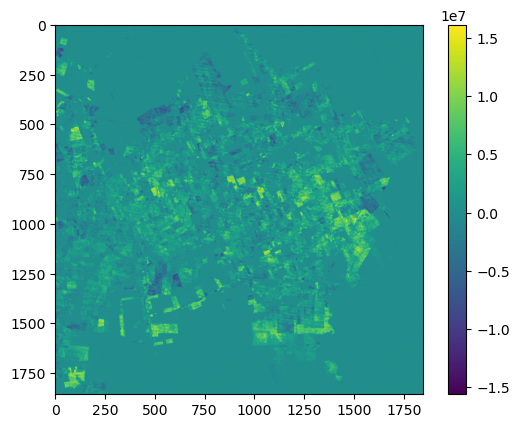

tiff array shape: (1856, 1847, 5)


In [6]:
# Constructing an array based off the Blob
tiff_array = convert_to_tiff(blob)
plot = tiff_array[:, :, 0]

# Plotting a part of the Blob
plt.imshow(plot)  
plt.colorbar() 
plt.show()

# print(tiff_array)
tiff_array_shape = tiff_array.shape
print(f"tiff array shape: {tiff_array_shape}")
# print(len(tiff_array))

In [7]:
#Constructing a model based on one just one pixel
model = read_model(tiff_array, 0, 0)

#Generating our dependents based off the date
date = datetime(year = 2020, month = 12, day = 25)
# 2020-12-01  2021, 5, 12
dependents = construct_dependents(date)

#Printing our Y_pred for one pixel
pred = pred_equation(model, dependents)
print(pred)

<xarray.DataArray ()>
array(7982.35708418)


In [8]:
# Getting the Y_pred for the whole array (image) based on one date
pred_array = pred_equation_array(tiff_array, date)
print(pred_array.shape)

(1856, 1847, 1)


In [9]:
# Getting the Y_pred for the whole array (image) based on a list of custom dates
start_date = datetime(year = 2022, month=  5, day = 12)
date_list = [start_date + timedelta(days = i) for i in range(5)]

arr = pred_equation_array_dates(tiff_array, date_list)
print(len(arr))

5


In [33]:
# Getting the Y_Image for the whole array (image) from a list of dates from LandSat
coordinates, h, v = boxes(-67, -9, scale = 0.5)
tile = Polygon(coordinates, geodesic=False)

endmembers = np.array([[500, 900, 400, 6100, 3000, 1000],
                       [1400, 1700, 2200, 3000, 5500, 3000],
                       [2000, 3000, 3400, 5800, 6000, 5800],
                       [0, 0, 0, 0, 0, 0],
                       [9000, 9600, 8000, 7800, 7200, 6500]], dtype=np.int16)
time_range = ['2020-12-31', '2021-12-31']
# time_range = ['2020-12-31', '2020-12-31']
landsat_stack = get_landsat_stack(time_range[0], time_range[1], tile, chunksize=32)

# Generate the time values from the Landsat Stack
time_values = landsat_stack.time.values

# Convert the NumPy datetime64 array to a Python DateTime Array
dates = [datetime.utcfromtimestamp(dt.astype('O') / 1e9) for dt in time_values]

/tmp/ipykernel_407/1665587233.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return 'EPSG: ' + str(mode(epsgs).mode[0])
/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [34]:
# Generating the Y_Pred from the tiff array based off a list of dates from LandSat

# Reshaping the tiff array so it matches the data from LandSat
reshape = tiff_array.reshape(1847, 1856, 5)

# Y_pred = pred_equation_array_dates(reshape, dates)
Y_pred = pred_equation_array(reshape, dates[0])
Y_pred_arr = np.array(Y_pred)

# splice_arr = image_arr[:1][:1][:1]
# splice = splice_arr.compute()
# Y_image_arr = image_arr.compute()

time_arr = Y_image['time']
x_arr = Y_image['x'].values
y_arr = Y_image['y'].values

# Create a numpy array for Y_image
Y_image_arr = np.zeros((len(x_arr), len(y_arr)))
Y_image_arr[:x_arr.shape[0], :] = x_arr[:, np.newaxis]
Y_image_arr[:, :y_arr.shape[0]] = y_arr[np.newaxis, :]


# Splicing the array to try and do the calculation
# xr.compute()



#---------------------------------------------------
# TODO: Check the computation of X and Y  (CHECK)
# TODO: Combine into a numpy array or list
# score = (predict - image) / RSME
# **loop over 46 days**
# Show for one day what the score (and image) looks like
# See if you can run it on 46 days with the help of dask
#---------------------------------------------------



# xarray.compute - normally use dask --> slice it smaller 100 x 100 --> look at dask on microsoft tutorial -> just do the first one to start
# Check notebook for display --> display should trigger the computation automatically, microsoft example should have it too (cloudless mosaic)

# residual = calculate_residual(Y_pred, Y_image)
# print(residual)

#RSME is one of the 5 bands
# 46 residuals, 46 scores, 1 rmse


# Y_image
# residual

In [28]:
# from dask.distributed import Client, progress
# client = Client(processes=False, threads_per_worker=4,
#                 n_workers=1, memory_limit='2GB')
# client

In [39]:
# value = Y_image[0, 0, 0].compute().item()
# value = Y_image[0, 0, 0].values
# print(value)


# plt.imshow(Y_image[1,1,1], cmap='viridis')  
# plt.colorbar() 
# plt.show()

# Try and do Y_pred and Y_image with one splice
# Check the calculations and make sure they are right
#If too slow go to scale with dask
